# Preparing `ssd_mobilenetv2` for Hailo-8

This notebook downloads a ssd_mobilnetv2 model from tensorflow object detection repo and passes it to the model translation tool chain: parsing, quantization, compilation. At each step, the intermediate HAR files are saved as [model_name]_orig.har, [model_name]_float.har, [model_name]_quantized.har.

In the compilation step, the [model_name].har and [model_name].hef files are saved.

At the end, 'hailo benchmark' is called to measure performance of the model on the Hailo-8 hardware. You need to have the hardware connected in order to run that step.

For calibration, a set of 32-64 images must be provided. Please set the below variable IMAGE_DIR accordingly.

Another notebook ssd_mobilenetv2_300x300_infer.ipynb, takes the HAR and HEF files produced by this notebook and can run the original CKPT model and the Hailo translated models on the host PC or the hardware to produce jpeg images with bounding boxes & scores around the detected objects. It can be used to visually validate the quality of the translated model for Hailo.

In [1]:
from pathlib import Path
import os

#MODEL      = 'ssd_mobilenet_v2_coco_2018_03_29' # 16.67 M parameters
#NMS_CONFIG_FILE= 'mobilenet_v2_nms_postprocess_config.json'

# The lite version uses depthwise convolution for Box encoding and in overall is 4.46 M parameters 
MODEL      = 'ssdlite_mobilenet_v2_coco_2018_05_09'
NMS_CONFIG_FILE= 'mobilenet_v2_ssdlite_nms_postprocess_config.json'

INPUT_WIDTH=1280
INPUT_HEIGHT=720

# Set IMAGE_DIR to point to your input *.jpg images which will be used for calibration
HOME_DIR = str(Path.home())
IMAGE_DIR = HOME_DIR + '/workspace/datasets/coco/val2017'
# Set max number of images used for calibration
MAX_NUM_IMAGES= 64

BATCH_SIZE= 8

FPS= 196

WORKDIR= str(Path.cwd())
print (WORKDIR)
TMPMODEL= WORKDIR+"/tmpmodel"
!mkdir -p {TMPMODEL}

/home/victorc/workspace/mymodels/ssd_mobilenetv2


In [2]:
# Find Virtual environment path
import subprocess as sp
python3Path = sp.getoutput('which python3')
endPos= python3Path.find("/bin/python3")
if (endPos== -1):
    print ("Error could not find virtualenv path")
else:
    VENV_PATH= python3Path[0:endPos]
print("Virtual environment located at " + VENV_PATH)
        

Virtual environment located at /home/victorc/workspace/dataflow_compiler/hailo_virtual_env


In [3]:
import tensorflow as tf
import numpy as np
from hailo_sdk_client import ClientRunner, __version__, NNFramework
from hailo_sdk_common.preprocessing import Normalization

/home/victorc/workspace/dataflow_compiler/hailo_virtual_env/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [4]:
print('TF version:', tf.__version__)
print('Hailo DFC version', __version__)

TF version: 2.4.1
Hailo DFC version 3.15.0


### __Downloading the model from a google repo__

In [5]:
%cd {TMPMODEL}
!wget -N --referer='http://css-tricks.com/forums/topic/font-face-in-base64-is-cross-browser-compatible/' http://download.tensorflow.org/models/object_detection/{MODEL}.tar.gz
!tar -zxf {MODEL}.tar.gz -C {TMPMODEL}

/home/victorc/workspace/mymodels/ssd_mobilenetv2/tmpmodel
--2022-04-12 15:45:32--  http://download.tensorflow.org/models/object_detection/ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 2607:f8b0:4002:c10::80, 108.177.122.128
Connecting to download.tensorflow.org (download.tensorflow.org)|2607:f8b0:4002:c10::80|:80... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz’ not modified on server. Omitting download.



### __Parse the model to Hailo HAR file__

In [6]:
SAVED_MODEL_PATH= TMPMODEL + "/" + MODEL + "/saved_model"
CKPT_MODEL_PATH= TMPMODEL + "/" + MODEL + '/model.ckpt'
print (CKPT_MODEL_PATH)

/home/victorc/workspace/mymodels/ssd_mobilenetv2/tmpmodel/ssdlite_mobilenet_v2_coco_2018_05_09/model.ckpt


In [7]:
#start_node = 'input_tensor'
start_node = 'FeatureExtractor/MobilenetV2/MobilenetV2/Conv2d_0/Conv2D'
start_node = 'FeatureExtractor/MobilenetV2/Conv/Conv2D'

#start_node = 'input_tensor'
end_nodes  = [
    'BoxPredictor_0/BoxEncodingPredictor/BiasAdd',
    'BoxPredictor_0/ClassPredictor/BiasAdd',
    'BoxPredictor_1/BoxEncodingPredictor/BiasAdd',
    'BoxPredictor_1/ClassPredictor/BiasAdd',
    'BoxPredictor_2/BoxEncodingPredictor/BiasAdd',
    'BoxPredictor_2/ClassPredictor/BiasAdd',
    'BoxPredictor_3/BoxEncodingPredictor/BiasAdd',
    'BoxPredictor_3/ClassPredictor/BiasAdd',
    'BoxPredictor_4/BoxEncodingPredictor/BiasAdd',
    'BoxPredictor_4/ClassPredictor/BiasAdd',
    'BoxPredictor_5/BoxEncodingPredictor/BiasAdd',
    'BoxPredictor_5/ClassPredictor/BiasAdd'
]

mean_list = [127.5, 127.5, 127.5]
std_list = [127.5, 127.5, 127.5]
norm_obj = Normalization(mean_list, std_list)

tensor_shape = {'Preprocessor/sub:0' : [1,300,300,3]}

runner = ClientRunner()
_ = runner.translate_tf_model(CKPT_MODEL_PATH,
    MODEL,
    start_node_name=start_node,
    end_node_names=end_nodes,
    #tensor_shapes=tensor_shape, # comment out this line for ssdlite
    integrated_preprocess=norm_obj)#, nn_framework=NNFramework.TENSORFLOW2)

INFO:tensorflow:Restoring parameters from /tmp/tmpk3x1yf9d/ssdlite_mobilenet_v2_coco_2018_05_09.ckpt
[info] Restored TF model ssdlite_mobilenet_v2_coco_2018_05_09.
[info] Translation started on TF model ssdlite_mobilenet_v2_coco_2018_05_09
[info] Translation completed on TensorFlow 1.x model ssdlite_mobilenet_v2_coco_2018_05_09
[info] Initialized runner for ssdlite_mobilenet_v2_coco_2018_05_09
[info] Nullified 908 of the channels in the model


In [8]:
MODEL_ORIG_HAR= MODEL + '_orig.har'
runner.save_har(MODEL_ORIG_HAR)

### __After parsing, add a YUV, resize layer to the network__

In [9]:
from hailo_sdk_client.tools.hn_modifications import add_resize_input_layers, add_yuv_to_rgb_layers

add_yuv_to_rgb_layers(runner)
add_resize_input_layers(runner, [INPUT_HEIGHT, INPUT_WIDTH])

[info] Adding YUV to RGB layers
[info] Nullified 908 of the channels in the model
[info] Adding resize input layers


### __Add on-chip post-processing layer by calling add_nms_postprocess()__

Note that a json config file that describes some parameters must be passed to it.
Please refer to documentation NMS_API.pdf to understand how to write this JSON file.
For the ssdlite_mobilenet_v2_coco_2018_05_09, we just used the file mobilenet_v2_ssd_nms_postprocess_config.json from the hailo model zoo located in {HMZ_DATA}/models_files/ObjectDetection/Detection-COCO/ssd/ssd_mobilenet_v2/pretrained where HMZ_DATA is an the environment variable introduced in https://github.com/hailo-ai/hailo_model_zoo/blob/master/docs/DATA.md .
Note that for the purpose of this notebook, we renamed mobilenet_v2_ssd_nms_postprocess_config.json to mobilenet_v2_ssdlite_nms_postprocess_config.json since this notebook supports both the non-lite and lite version of ssd mobilenetv2.

In [10]:
from hailo_sdk_client.tools.core_postprocess.core_postprocess_api import add_nms_postprocess
from hailo_sdk_common.targets.inference_targets import ParamsKinds
add_nms_postprocess(runner, config_json_path=WORKDIR + '/' + NMS_CONFIG_FILE, params_kind=ParamsKinds.NATIVE)

[info] Initialized runner for ssdlite_mobilenet_v2_coco_2018_05_09
[info] Nullified 908 of the channels in the model


In [11]:
MODEL_FLOAT_HAR= MODEL + '_rsz_yuv_float.har'
runner.save_har(MODEL_FLOAT_HAR)

In [12]:
!hailo visualizer {MODEL_FLOAT_HAR}

2022-04-12 15:45:42.207494: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-12 15:45:42.207515: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/victorc/workspace/dataflow_compiler/hailo_virtual_env/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or t

Run the profiler to check if any resource allocation issue arises.

In [13]:
!hailo profiler --mode pre_placement {MODEL_FLOAT_HAR}

2022-04-12 15:45:44.861419: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-12 15:45:44.861441: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/victorc/workspace/dataflow_compiler/hailo_virtual_env/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or t

[info] 
Model Details
---------------------------  ----------
Input Tensors Shapes         720x1280x3
Operations per Input Tensor  1.50 GOPs
Operations per Input Tensor  0.76 GMACs
Model Parameters             4.46 M
---------------------------  ----------

Profiler Input Settings
-----------------  ----------------
Optimization Goal  Reach 172.20 FPS
Profiler Mode      Pre Placement
-----------------  ----------------

Performance Summary
-------------------------------  -----------
Number of Devices                1
Throughput (Bottleneck Layer)    172.20 FPS
Latency                          25.43 ms
Total NN Core Power Consumption  0.57 W
Operations per Second            0.01 GOP/s
Operations per Second            0.00 GMAC/s
-------------------------------  -----------


### Quantizing the model

For simplicity, in this case we're going to have a false quantization. This will NOT produce real results, until quantizing with real data

In [14]:
import PIL
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

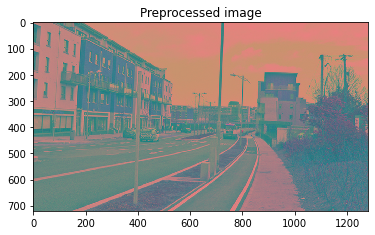

In [15]:
def convert_rgb_to_yuv(image):
    transition_matrix = np.array([[0.2568619, -0.14823364, 0.43923104],
                                  [0.5042455, -0.2909974, -0.367758],
                                  [0.09799913, 0.43923104, -0.07147305]])
    image = np.matmul(image, transition_matrix)
    image += [16, 128, 128]
    return image

def preproc_yuv_resize(path):  
    pil_image = Image.open(path)
    ip = pil_image.resize([INPUT_WIDTH, INPUT_HEIGHT])
    ip = np.array(ip)
    ip = convert_rgb_to_yuv(ip)
    return ip

files = os.listdir(IMAGE_DIR)
files.sort()
files = files[0:MAX_NUM_IMAGES]
idx= 0
calib_dataset = np.zeros((len(files), INPUT_HEIGHT, INPUT_WIDTH, 3), dtype=np.float32)
for filename in files:
    if(os.path.isfile(os.path.join(IMAGE_DIR, filename)) and ('.jpg' in filename)):
        img_preproc= preproc_yuv_resize(os.path.join(IMAGE_DIR,filename))
        calib_dataset[idx,:,:,:] = img_preproc.astype(np.uint8)
        idx=idx+1
        
plt.imshow(np.array(calib_dataset[idx-1,:,:,:], np.uint8), interpolation='nearest')
plt.title('Preprocessed image')
plt.show()

Create a quantization/compilation script in which last line sets the resizer operating mode to streaming. This is to avoid errors such as "Hailo tools builder failed: Model uses too many reources: 119 L4 memory cuts"

In [16]:
CALIB_SET_SIZE= len(files)
with open('model.alls', 'w') as FH:
    FH.write(f'model_optimization_config(calibration, batch_size={BATCH_SIZE})\n')
    FH.write(f'model_optimization_config(calibration, calibset_size={CALIB_SET_SIZE})\n')
    FH.write('post_quantization_optimization(bias_correction, policy=enabled)\n')
    FH.write('compilation_param({*}, resources_allocation_strategy=min_l3_mem_match_fps)\n')
    FH.write('compilation_param({conv*}, balance_output_multisplit=False)\n')
    FH.write('compilation_param(resize_input1, resize_bilinear_streaming=True)\n')
    FH.write('allocator_param(automatic_ddr= False )\n')

In [17]:
runner.quantize(calib_dataset)
MODEL_QUANTIZED_HAR= MODEL + '_rsz_yuv_quantized.har'
runner.save_har(MODEL_QUANTIZED_HAR)

[info] Starting Quantization
[info] Creating graph from hn
[warning] Layer type bbox_decoder is not yet supported..
Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
Instructions for updating:
Use fn_output_signature instead
[info] Starting Equalization
[info] Equalization configuration:
[info]     Default policy: enabled
[info]     Mode: min_based
[info] Starting Equalization of component 1 out of 1
[info] Skipped Equalization of layers {'ssdlite_mobilenet_v2_coco_2018_05_09/conv28_linear0', 'ssdlite_mobilenet_v2_coco_2018_05_09/conv51_linear0', 'ssdlite_mobilenet_v2_coco_2018_05_09/conv47_linear0', 'ssdlite_mobilenet_v2_coco_2018_05_09/conv43_linear0', 'ssdlite_mobilenet_v2_coco_2018_05_09/c

### Compiling the model

Pass the script as argument

In [18]:
hef = runner.get_hw_representation(allocator_script_filename='model.alls', fps= FPS)

[warning] Taking model script commands from model.alls and ignoring previous allocation script commands


In [19]:
MODEL_HAR= MODEL + '_rsz_yuv.har'
runner.save_har(MODEL_HAR)

HEF_FILE= MODEL + '_rsz_yuv.hef'
with open(HEF_FILE, 'wb') as FH:
    FH.write(hef)

### Verify performance on the target if connected

In [24]:
#Comment below line if no hardware is connected
!hailo benchmark {HEF_FILE}

2022-04-12 15:58:23.032888: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-12 15:58:23.032911: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/victorc/workspace/dataflow_compiler/hailo_virtual_env/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or t